In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils import class_weight

# Set your dataset path
data_dir = (r"TrashType_Image_Dataset")
img_size = (224, 224)
batch_size = 32


In [39]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Confirm class labels
print("Class indices:", train_gen.class_indices)


Found 2022 images belonging to 2 classes.
Found 505 images belonging to 2 classes.
Class indices: {'biodegradable': 0, 'non-biodegradable': 1}


In [40]:
# Compute class weights
labels = train_gen.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 1.2669172932330828, 1: 0.8259803921568627}


In [41]:
# Load pretrained model
base_model = MobileNetV2(include_top=False, input_shape=(*img_size, 3), weights='imagenet')
base_model.trainable = True  # Unfreeze full model

# Optional: Freeze some bottom layers to speed up training
for layer in base_model.layers[:-50]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile with a low learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,856,385 (7.08 MB)

 Non-trainable params: 402,880 (1.54 MB)

In [42]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights
)


C:\Users\dekat\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.6680 - loss: 0.6224 - val_accuracy: 0.9208 - val_loss: 0.3140
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8356 - loss: 0.3944 - val_accuracy: 0.9327 - val_loss: 0.2243
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8807 - loss: 0.3048 - val_accuracy: 0.9465 - val_loss: 0.1799
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8954 - loss: 0.2548 - val_accuracy: 0.9347 - val_loss: 0.1714
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9250 - loss: 0.2214 - val_accuracy: 0.9366 - val_loss: 0.1539
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9169 - loss: 0.2036 - val_accuracy: 0.9386 - val_loss: 0.1507
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9286 - loss: 0.1826 - val_accuracy: 0.9465 - val_loss: 0.1406
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9437 - loss: 0.1557 - val_accuracy: 0.9485 - v

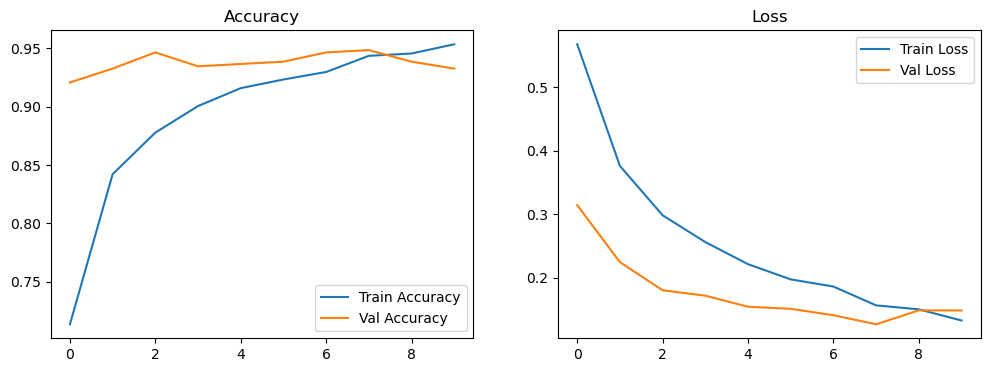

In [46]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [47]:
model.save("waste_biodegradable_classifier_fixed.h5")


In [59]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load model
model = load_model("waste_biodegradable_classifier_fixed.h5")

def predict_image(path):
    img = image.load_img(path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)[0][0]
    
    # Use correct threshold based on class_indices
    print("Prediction Score:", prediction)
    return "Biodegradable" if prediction < 0.5 else "Non-Biodegradable"

# Example
print(predict_image(r"TrashType_Image_Dataset\\non-biodegradable\\glass\\glass_452.jpg"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction Score: 0.9934276
Non-Biodegradable


In [60]:
pip install streamlit tensorflow pillow


Note: you may need to restart the kernel to use updated packages.
